In [1]:
#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import random
from deap import base, creator, tools, algorithms
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from deap import tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

***loading data***

In [2]:
X = pd.read_csv('feature_selection/X_selected.csv')
target = pd.read_csv('feature_selection/y.csv')
y = target['MEDV']

#standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# **GA** ***main code :***

In [3]:

BOUNDS = {
    "C": (0.1, 100),
    "epsilon": (0.001, 1),
    "gamma": (1e-5, 10)  # Added gamma
}

# Evaluation function for the genetic algorithm
def evaluate(individual):

    # Clip individual parameters to their bounds
    C = max(BOUNDS["C"][0], min(individual[0], BOUNDS["C"][1]))
    epsilon = max(BOUNDS["epsilon"][0], min(individual[1], BOUNDS["epsilon"][1]))
    gamma = max(BOUNDS["gamma"][0], min(individual[2], BOUNDS["gamma"][1])) # Get gamma

    svr = SVR(kernel="rbf", C=C, epsilon=epsilon, gamma=gamma) # Use gamma
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse,

# Mutation function with clipping
def mutate_and_clip(individual):
    tools.mutGaussian(individual, mu=0, sigma=0.1, indpb=0.2)
    for i in range(len(individual)):
        individual[i] = max(BOUNDS[list(BOUNDS.keys())[i]][0], min(individual[i], BOUNDS[list(BOUNDS.keys())[i]][1]))
    return individual,

# Decorator for boundary checking
def checkBounds(min_vals, max_vals):
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for child in offspring:
                for i in range(len(child)):
                    child[i] = max(min_vals[i], min(child[i], max_vals[i]))
            return offspring
        return wrapper
    return decorator

# Set up DEAP framework
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize MSE
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.1, 10)  # C
toolbox.register("attr_epsilon", random.uniform, 0.01, 0.5)  # epsilon
toolbox.register("attr_gamma", random.uniform, 0.01, 1)  # gamma # Added gamma

# Create an individual as a list of C, epsilon and gamma values
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_float, toolbox.attr_epsilon, toolbox.attr_gamma), n=1) # Added gamma
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the genetic algorithm functions
toolbox.register("mate", tools.cxBlend, alpha=0.5)

# Ensure parameters stay within the valid range after mutation
min_bounds = [BOUNDS["C"][0], BOUNDS["epsilon"][0], BOUNDS["gamma"][0]] # Added gamma
max_bounds = [BOUNDS["C"][1], BOUNDS["epsilon"][1], BOUNDS["gamma"][1]] # Added gamma
toolbox.register("mutate", mutate_and_clip)
toolbox.decorate("mutate", checkBounds(min_bounds, max_bounds))
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Create the population
population = toolbox.population(n=256)

# Run the Genetic Algorithm with error history


# **SVR** model

In [4]:
c = 1.0
e = 0.1
g = 0.1
model_svr = SVR(kernel='rbf', C=c, epsilon=e, gamma=g)

model_svr.fit(X_train, y_train)

y_pred = model_svr.predict(X_test)


In [5]:
# Calculate R^2 score (accuracy)
accuracy = r2_score(y_test, y_pred)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)

print(f"without optimization")
print(f"Accuracy (R^2 Score): {accuracy}")
print(f"MSE: {mse}")

without optimization
Accuracy (R^2 Score): 0.7363795927585206
MSE: 19.332281781282678


# **GA** Optimized

In [6]:
algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.1, ngen=75, verbose=True)

# Extract the best individual
best_individual = tools.selBest(population, 1)[0]
print(f"Best parameters found by GA: C={best_individual[0]}, epsilon={best_individual[1]}, gamma={best_individual[2]}")

gen	nevals
0  	256   
1  	185   
2  	168   
3  	204   
4  	199   
5  	185   
6  	179   
7  	176   
8  	187   
9  	168   
10 	199   
11 	181   
12 	196   
13 	173   
14 	176   
15 	191   
16 	186   
17 	175   
18 	184   
19 	192   
20 	187   
21 	182   
22 	173   
23 	184   
24 	191   
25 	189   
26 	194   
27 	185   
28 	192   
29 	191   
30 	173   
31 	181   
32 	180   
33 	183   
34 	181   
35 	184   
36 	186   
37 	193   
38 	195   
39 	187   
40 	169   
41 	187   
42 	165   
43 	187   
44 	187   
45 	190   
46 	173   
47 	180   
48 	166   
49 	174   
50 	174   
51 	185   
52 	188   
53 	188   
54 	195   
55 	180   
56 	176   
57 	193   
58 	190   
59 	182   
60 	180   
61 	196   
62 	188   
63 	172   
64 	163   
65 	190   
66 	196   
67 	205   
68 	186   
69 	193   
70 	199   
71 	196   
72 	205   
73 	189   
74 	186   
75 	174   
Best parameters found by GA: C=42.45845014856052, epsilon=0.27443419797310387, gamma=0.2159335540383689


In [7]:
# Train the SVR model with the optimized parameters
best_C, best_epsilon, best_gamma = best_individual
svr_optimized = SVR(kernel="rbf", C=best_C, epsilon=best_epsilon, gamma=best_gamma)
svr_optimized.fit(X_train, y_train)

# Make predictions with the optimized model
y_pred_optimized = svr_optimized.predict(X_test)

# Evaluate the optimized model
accuracy_optimized = svr_optimized.score(X_test, y_test)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
print(f"Mean Squared Error (SVR with GA optimization): {mse_optimized}")
print(f"Accuracy Score (SVR with GA optimization): {accuracy_optimized}")


Mean Squared Error (SVR with GA optimization): 8.574932789185658
Accuracy Score (SVR with GA optimization): 0.8830698155795527


In [9]:
diff = (accuracy_optimized - accuracy)* 100
print(f"diff in Accuracy: {diff:.2f} %")

improvement = (accuracy_optimized - accuracy) / accuracy * 100
print(f"Improvement in Accuracy: {improvement:.2f} %")

diff in Accuracy: 14.67 %
Improvement in Accuracy: 19.92 %


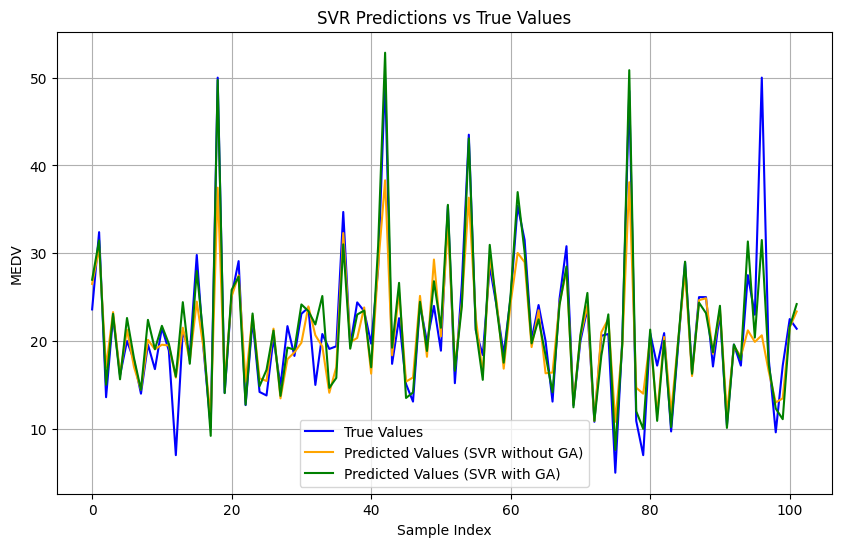

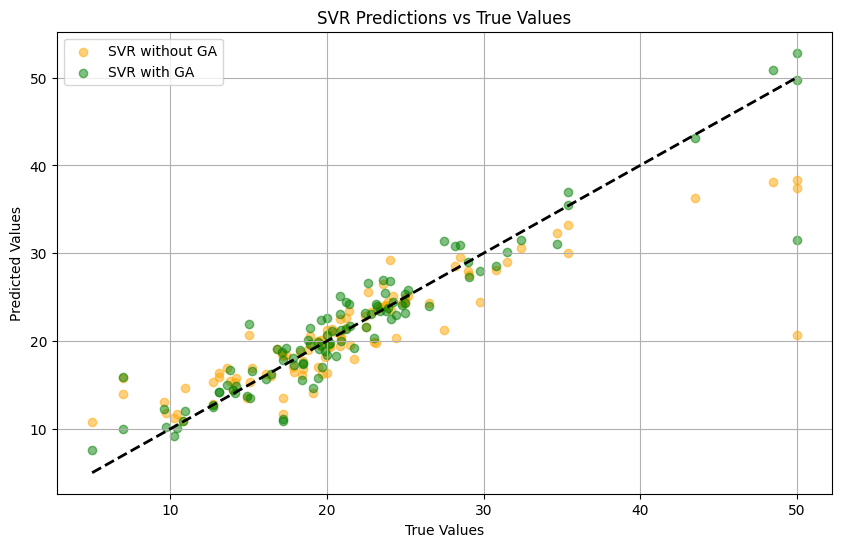

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True Values', color='blue')
plt.plot(y_pred, label='Predicted Values (SVR without GA)', color='orange')
plt.plot(y_pred_optimized, label='Predicted Values (SVR with GA)', color='green')
plt.title('SVR Predictions vs True Values')
plt.xlabel('Sample Index')
plt.ylabel('MEDV')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, label='SVR without GA', color='orange', alpha=0.5)
plt.scatter(y_test, y_pred_optimized, label='SVR with GA', color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('SVR Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()
